In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4
!nvidia-smi

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4
Wed Nov  8 20:04:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   51C    P0    72W / 275W |      3MiB / 81920MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM... 

In [2]:
import hydra
from hydra.utils import instantiate
from hydra import initialize, compose

In [3]:
import sys
import os
import getpass

os.chdir('/home/' + getpass.getuser() + '/Projects/CaloQVAE/')
sys.path.insert(1, '/home/' + getpass.getuser() + '/Projects/CaloQVAE/')

In [4]:
#external libraries
import os
import pickle
import datetime
import sys
import yaml
import json

import torch.optim as optim
import torch
from torch import nn
from torch.nn.functional import binary_cross_entropy_with_logits
torch.manual_seed(32)
import numpy as np
np.random.seed(32)
import matplotlib.pyplot as plt
import hydra
from hydra.utils import instantiate

from omegaconf import OmegaConf

import time

# PyTorch imports
from torch import device, load, save
from torch.nn import DataParallel
from torch.cuda import is_available

# Add the path to the parent directory to augment search for module
sys.path.append(os.getcwd())
    
# Weights and Biases
import wandb

#self defined imports
from CaloQVAE import logging

[20:04:49.592] INFO   CaloQVAE                                          Willkommen!
[20:04:49.593] INFO   CaloQVAE                                          Loading configuration.


In [5]:
logger = logging.getLogger(__name__)

from data.dataManager import DataManager
from utils.plotting.plotProvider import PlotProvider
from engine.engine import Engine
from models.modelCreator import ModelCreator

from utils.plotting.HighLevelFeatures import HighLevelFeatures as HLF
HLF_1_photons = HLF('photon', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_photons.xml', wandb=False)
HLF_1_pions = HLF('pion', filename='/raid/javier/Datasets/CaloVAE/data/atlas/binning_dataset_1_pions.xml', wandb=False)
HLF_1_electron = HLF('electron', filename='/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3/binning_dataset_2.xml', wandb=False)

[20:04:50.112] INFO   numexpr.utils                                     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[20:04:50.113] INFO   numexpr.utils                                     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[20:04:50.114] INFO   numexpr.utils                                     NumExpr defaulting to 8 threads.
2023-11-08 20:04:50,538 dwave.cloud INFO  MainThread Log level for 'dwave.cloud' namespace set to 0
[20:04:50.538] INFO   dwave.cloud                                       Log level for 'dwave.cloud' namespace set to 0


In [6]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="configs")

hydra.initialize()

In [7]:


# config=compose(config_name="config.yaml")
config=compose(config_name="config.yaml")
wandb.init(project="caloqvae", entity="qvae", config=config, mode='disabled')
modelCreator = ModelCreator(cfg=config)
dataMgr = DataManager(cfg=config)
#initialise data loaders
dataMgr.init_dataLoaders()
#run pre processing: get/set input dimensions and mean of train dataset
dataMgr.pre_processing()

if config.model.activation_fct.lower()=="relu":
    modelCreator.default_activation_fct=torch.nn.ReLU()
elif config.model.activation_fct.lower()=="tanh":
    modelCreator.default_activation_fct=torch.nn.Tanh()
else:
    logger.warning("Setting identity as default activation fct")
    modelCreator.default_activation_fct=torch.nn.Identity()

#instantiate the chosen model
#loads from file 
model=modelCreator.init_model(dataMgr=dataMgr)

#create the NN infrastructure
model.create_networks()

/raid/javier/anaconda3/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'config.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)
[20:04:51.634] INFO   data.dataManager                                  Loading Data
[20:04:58.077] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fee24bd5d10>: 80000 events, 625 batches
[20:04:58.078] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fee2427f350>: 10000 events, 10 batches
[20:04:58.078] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fee24295a10>: 10000 events, 10 batches
[20:05:00.496] INFO   models.modelCreator                               Initialising Model Type GumBoltAtlasPRBMCNN
2023-11-08 20:05:00

Initializing NetworkV3


In [8]:
#Not printing much useful info at the moment to avoid clutter. TODO optimise
model.print_model_info()
# for name, param in model.named_parameters():
#         print(name, param.requires_grad)

# Load the model on the GPU if applicable
# dev = None
# if (config.device == 'gpu') and config.gpu_list:
#     logger.info('Requesting GPUs. GPU list :' + str(config.gpu_list))
#     devids = ["cuda:{0}".format(x) for x in list(config.gpu_list)]
#     logger.info("Main GPU : " + devids[0])

#     if is_available():
#         print(devids[0])
#         dev = device(devids[0])
#         if len(devids) > 1:
#             logger.info(f"Using DataParallel on {devids}")
#             model = DataParallel(model, device_ids=list(config.gpu_list))
#         logger.info("CUDA available")
#     else:
#         dev = device('cpu')
#         logger.info("CUDA unavailable")
# else:
#     logger.info('Requested CPU or unable to use GPU. Setting CPU as device.')
#     dev = device('cpu')
dev = torch.device("cuda:0")

# Send the model to the selected device
# model.to(dev)
# Log metrics with wandb
wandb.watch(model)

# For some reason, need to use postional parameter cfg instead of named parameter
# with updated Hydra - used to work with named param but now is cfg=None 
engine=instantiate(config.engine, config)

#TODO for some reason hydra double instantiates the engine in a
#newer version if cfg=config is passed as an argument. This is a workaround.
#Find out why that is...
engine._config=config
#add dataMgr instance to engine namespace
engine.data_mgr=dataMgr
#add device instance to engine namespace
engine.device=dev    
#instantiate and register optimisation algorithm
engine.optimiser = torch.optim.Adam(model.parameters(),
                                    lr=config.engine.learning_rate)
#add the model instance to the engine namespace
engine.model = model
# add the modelCreator instance to engine namespace
engine.model_creator = modelCreator
engine.model = engine.model.to(dev)

[20:05:06.089] INFO   models.autoencoders.autoencoderbase               _dataset_mean: torch.Size([1, 6480])
[20:05:06.090] INFO   wandb                                             Watching
/raid/javier/anaconda3/lib/python3.11/site-packages/coffea/util.py:154: FutureWarning: In coffea version v2023.3.0 (target date: 31 Mar 2023), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)
[20:05:06.370] INFO   engine.engineAtlas                                Setting up engine Atlas.
[20:05:06.371] INFO   engine.engineCaloV3                               Setting up engine Calo.
[20:05:06.371] INFO   engine.engine                                     Setting up default engine.


In [9]:
train_loader,test_loader,val_loader = engine.data_mgr.create_dataLoader()

[20:05:13.334] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fecddead090>: 80000 events, 625 batches
[20:05:13.335] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fec5082cc10>: 10000 events, 10 batches
[20:05:13.336] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fec50349090>: 10000 events, 10 batches


In [10]:
###LOAD MODEL

In [11]:
def load_state(model, run_path, device):
        model_loc = run_path
        
        # Open a file in read-binary mode
        with open(model_loc, 'rb') as f:
            # Interpret the file using torch.load()
            checkpoint=torch.load(f, map_location=device)
            
            local_module_keys=list(model._modules.keys())
            for module in checkpoint.keys():
                if module in local_module_keys:
                    print("Loading weights for module = ", module)
                    getattr(model, module).load_state_dict(checkpoint[module])

In [12]:
# # generous-wave-3
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# modelname = 'generous-wave-3'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/13-46-23/wandb/run-20230822_134624-mn592vm0/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # # faithful-sunset-4
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'faithful-sunset-4'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/17-51-11/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# # lemon-water-5
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'lemon-water-5'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/18-36-38/wandb/run-20230822_183639-9adkmjtg/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # # atomic-glitter-6
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'atomic-glitter-6'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-22/19-39-35/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False


# # fearless-plasma-9
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fearless-plasma-9'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/13-58-19/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False

    
# # flowing-serenity-11
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fearless-plasma-9'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-23/14-41-33/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    

# # vocal-lake-17
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'vocal-lake-17'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-52-20/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # clean-pyramid-18
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'clean-pyramid-18'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-24/20-53-30/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # charmed-donkey-40
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'clean-pyramid-18'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-11-54/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
    
# # earnest-dragon-28
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'earnest-dragon-28'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/16-57-14/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# # fluent-cherry-39
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# modelname = 'fluent-cherry-39'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-28/20-00-21/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     # R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     R=0.002
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    
# # # effortless-valley-50
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'effortless-valley-50'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-30/12-55-16/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # likely-sun-62
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # modelname = 'likely-sun-62'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/14-59-50/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # wild-terrain-65
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_latest.pth"
# # modelname = 'wild-terrain-65'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-08-31/18-38-18/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # vague-cosmos-67
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # modelname = 'wild-terrain-65'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-16-06/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # cosmic-galaxy-68
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# # modelname = 'cosmic-galaxy-68'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/13-44-21/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # # sleek-sunset-71
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNN_atlas_default_best.pth"
# # # modelname = 'sleek-sunset-71'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-01/17-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     # R=0.002
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False


# # # revived-brook-81
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'revived-brook-81'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-04/00-39-34/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # # toasty-vortex-82
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'toasty-vortex-82'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/13-59-21/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # fearless-thunder-86
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fearless-thunder-86'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-05-54/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # vocal-vortex-87
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'vocal-vortex-87'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-31-01/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # peachy-valley-83
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'peachy-valley-83'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-05/14-19-17/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
    
# # # dulcet-wildflower-85
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'dulcet-wildflower-85'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-06/14-02-53/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


    
# # # clear-sponge-88
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'clear-sponge-88'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-07/13-37-06/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True


# # # efficient-field-94
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'clear-sponge-88'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-10/21-46-16/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
    
# # # wandering-puddle-97
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'wandering-puddle-97'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # wandering-puddle-97
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'wandering-puddle-97'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/16-02-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # cerulean-thunder-98
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'cerulean-thunder-98'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/17-21-33/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # fluent-snowball-99
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fluent-snowball-99'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-11/20-10-59/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # fluent-snowball-99
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_latest.pth"
# # modelname = 'fluent-snowball-99'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-12/15-43-59/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     # R=0.002
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # ruby-armadillo-178
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'ruby-armadillo-178'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-42-59/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # fancy-dragon-180
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'fancy-dragon-180'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/13-56-27/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True
    
    
# # # # dainty-violet-177
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # # modelname = 'dainty-violet-177'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/18-37-50/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False
    
    
# # # # faithful-cherry-179
# # # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # # modelname = 'faithful-cherry-179'
# # # datascaled = 'reduced'
# # # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-25/20-52-29/wandb/latest-run/files/config.yaml", 'r') as file:
# # #     model_config = yaml.safe_load(file)
# # #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# # #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# # #     scaled=False


# # # eager-blaze-184
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'eager-blaze-184'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-19-03/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # expert-butterfly-182
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'expert-butterfly-182'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-26/16-53-25/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # likely-gorge-188
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'likely-gorge-188'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-28/16-08-31/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False
    
    
# # # colorful-plasma-183
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'colorful-plasma-183'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-27/16-02-15/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=False

# # royal-cosmos-197
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'royal-cosmos-197'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-30/15-03-45/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # # dashing-lion-194
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'dashing-lion-194'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-09-29/15-56-19/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

# # # vocal-salad-202
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# # modelname = 'vocal-salad-202'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-51-57/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

# # # azure-resonance-201
# # run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# # modelname = 'azure-resonance-201'
# # datascaled = 'reduced'
# # with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/13-47-14/wandb/latest-run/files/config.yaml", 'r') as file:
# #     model_config = yaml.safe_load(file)
# #     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
# #     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
# #     scaled=True

In [13]:
# crimson-feather-207
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/18-13-17/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
modelname = 'crimson-feather-207'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/18-13-17/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# # fresh-flower-208
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/20-11-07/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'fresh-flower-208'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/20-11-07/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# misty-terrain-209
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-03/20-18-34/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'misty-terrain-209'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-03/20-18-34/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
# # jolly-dragon-213
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-04/18-35-06/wandb/latest-run/files/GumBoltCaloCRBM_atlas_default_best.pth"
# modelname = 'jolly-dragon-213'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-04/18-35-06/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # treasured-firefly-211
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-04/17-23-39/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'treasured-firefly-211'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-04/17-23-39/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True
    
    
# # splendid-donkey-214
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-05/14-14-33/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'splendid-donkey-214'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-05/14-14-33/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False


# # frosty-frog-218
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-06/19-06-48/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'frosty-frog-218'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-06/19-06-48/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = 0.04 #json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # fearless-cherry-220
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-10/15-50-58/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'fearless-cherry-220'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-10/15-50-58/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# # deft-oath-221 || Pions
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-10/16-44-39/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'deft-oath-221'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-10/16-44-39/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False


# # northern-meadow-223 || Pions
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-12/13-46-00/wandb/latest-run/files/GumBoltAtlasCRBMCNNDCond_atlas_default_best.pth"
# modelname = 'northern-meadow-223'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-12/13-46-00/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=False



# # polished-planet-227
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-20/20-38-52/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'polished-planet-227'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-20/20-38-52/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True


# enchanted-newt-231
run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-10-31/19-40-06/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
modelname = 'enchanted-newt-231'
datascaled = 'reduced'
with open("/home/javier/Projects/CaloQVAE/outputs/2023-10-31/19-40-06/wandb/latest-run/files/config.yaml", 'r') as file:
    model_config = yaml.safe_load(file)
    R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
    reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
    scaled=True
    
    
    
# # wobbly-meadow-233
# run_path = "/home/javier/Projects/CaloQVAE/outputs/2023-11-06/22-44-20/wandb/latest-run/files/GumBoltAtlasPRBMCNN_atlas_default_best.pth"
# modelname = 'enchanted-newt-231'
# datascaled = 'reduced'
# with open("/home/javier/Projects/CaloQVAE/outputs/2023-11-06/22-44-20/wandb/latest-run/files/config.yaml", 'r') as file:
#     model_config = yaml.safe_load(file)
#     R = json.loads(model_config["_content"]["value"]['engine'].replace("'", "\""))['r_param']
#     reducedata = True if model_config["_content"]["value"]["reducedata"] == 'True' else False
#     scaled=True



arch = config['model']['model_type']
part = config['data']['particle_type']
print(arch)
print(part)
print(scaled, reducedata)


# load_state(model, run_path, 'cuda:{0}'.format(cfg.gpu_list[0]))
load_state(model, run_path, dev)
model.eval();

GumBoltAtlasPRBMCNN
electron-ds2
True False
Loading weights for module =  _activation_fct
Loading weights for module =  _bce_loss
Loading weights for module =  _energy_activation_fct
Loading weights for module =  _hit_activation_fct
Loading weights for module =  _output_loss
Loading weights for module =  _hit_loss
Loading weights for module =  _hit_smoothing_dist_mod
Loading weights for module =  _inference_energy_activation_fct
Loading weights for module =  encoder
Loading weights for module =  prior
Loading weights for module =  decoder


In [14]:
hfont = {'fontname':'Helvetica'}
ds = {'electron-ds2':'Dataset 2', 'pion1':'Dataset 1: π'}

In [15]:
xx = next(iter(test_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

torch.Size([1024, 6480])


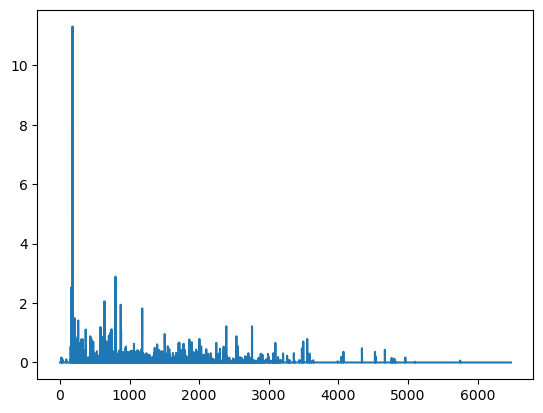

In [16]:
print(in_data.shape)
plt.plot(in_data.cpu().numpy()[3,:])

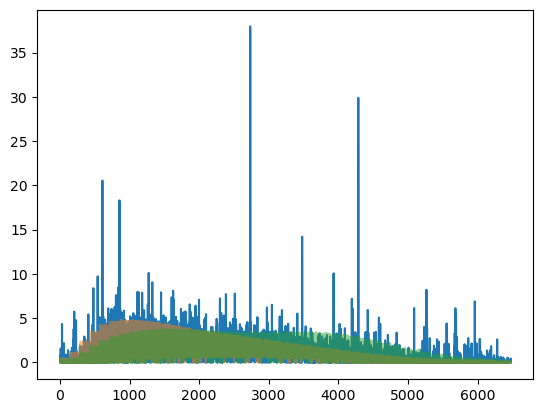

In [17]:
with torch.no_grad():
    in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
    # if reducedata:
        # in_data = engine._reduce(in_data, true_energy, R=R)
    fwd_output = engine.model((in_data, true_energy), True)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
idx = 12
plt.plot(in_data.cpu().numpy()[idx,:])
plt.plot(fwd_output.output_activations.detach().cpu().numpy()[idx,:], alpha=0.5)
plt.plot(sample_data.detach().cpu().numpy()[idx,:], alpha=0.5)

In [19]:
# enIn = torch.cat((in_data, true_energy), dim=1)
# beta, post_logits, post_samples = engine.model.encoder(enIn)
with torch.no_grad():
    # enIn = torch.cat((in_data, true_energy), dim=1)
    # beta, post_logits, post_samples = engine.model.encoder(enIn)
    beta, post_logits, post_samples = engine.model.encoder(in_data, true_energy)
# plt.plot(post_samples[0][0,:].detach().cpu().numpy())
post_samples = torch.cat(post_samples, 1)

In [21]:
# t0 = time.time() outputs = net(x) torch.cuda.current_stream().synchronize() t1 = time.time()

decoder_time = []
for i in range(500):
    # start = time.process_time()
    start = time.time()
    output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
    torch.cuda.current_stream().synchronize()
    t1 = time.time()
    decoder_time.append(t1 - start)
    # decoder_time.append(time.process_time() - start)

In [22]:
print(np.mean(decoder_time), np.std(decoder_time))

0.010469470977783203 0.0005546670617905547


Text(0, 0.5, 'decoder time (s)')

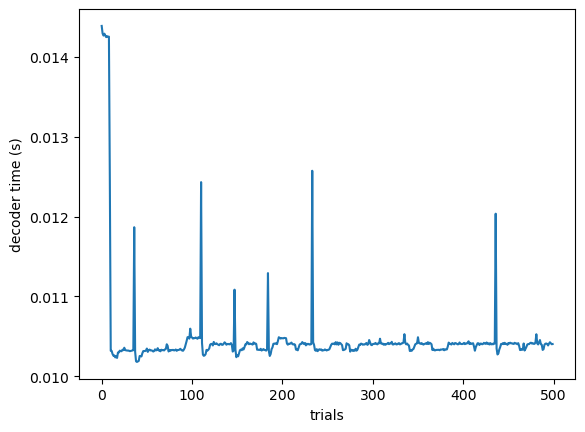

In [23]:
plt.plot(decoder_time)
plt.xlabel("trials")
plt.ylabel("decoder time (s)")

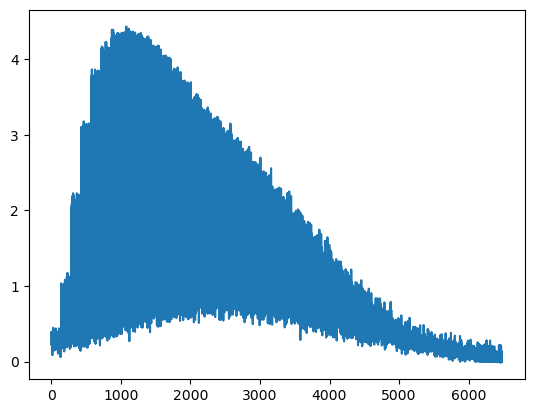

In [27]:
# post_samples = torch.cat([post_samples, true_energy], dim=1)
# post_samples = torch.cat(post_samples,1)
# output_hits, output_activations = engine.model.decoder(post_samples)
output_hits, output_activations = engine.model.decoder(post_samples, true_energy)
plt.plot(output_activations[idx,:].detach().cpu().numpy())


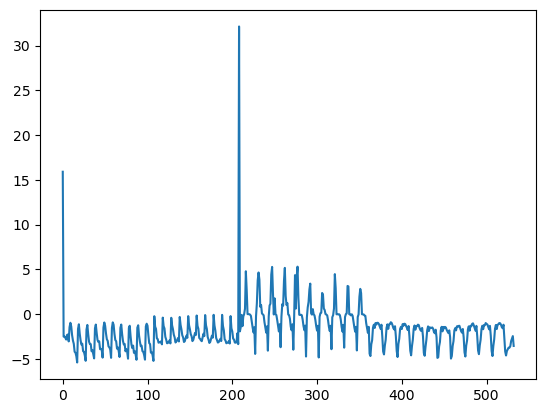

In [26]:
# self._hit_smoothing_dist_mod(output_hits, beta, is_training)
plt.plot(output_hits[1,:].detach().cpu().numpy())
beta = torch.tensor(5, dtype=torch.float, device=output_hits.device, requires_grad=False)

In [68]:
beta = torch.tensor(1, dtype=torch.float, device=output_hits.device, requires_grad=False)

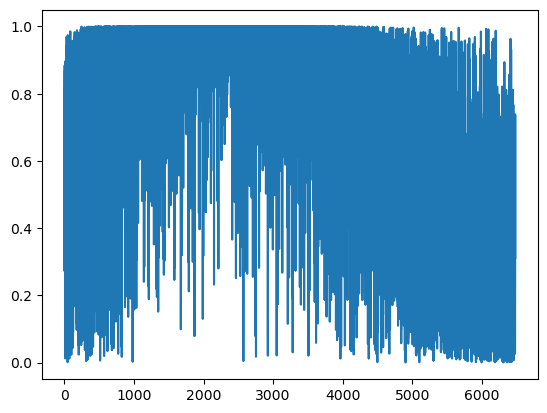

In [69]:
plt.plot(engine.model._hit_smoothing_dist_mod(output_hits, beta, True)[2,:].detach().cpu().numpy())

In [29]:
weight_dict = engine.model.prior.weight_dict

In [30]:
(weight_dict['01']==0).sum()

tensor(259267, device='cuda:0')

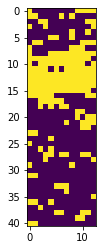

In [30]:
# engine.model._hit_smoothing_dist_mod(output_hits, torch.Tensor([5]), is_training=False)[idx,:].detach().cpu()
idx=5
# plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(23,16))
plt.imshow(torch.where(in_data > 0, 1., 0.)[idx,:].detach().cpu().numpy().reshape(41,13))

In [61]:
# fwd_output.output_activations.shape

In [554]:
(output_hits.sum(dim=0) == 0).sum()
engine._config.model.output_smoothing_fct

# engine.model._energy_activation_fct
beta = torch.tensor(engine._config.model.output_smoothing_fct, dtype=torch.float, device=output_hits.device, requires_grad=False)
output = engine.model._energy_activation_fct(output_activations) * engine.model._hit_smoothing_dist_mod(output_hits, beta, False)
o1 = engine.model._energy_activation_fct(output_activations)
o2 = engine.model._hit_smoothing_dist_mod(output_hits, beta, False)

In [555]:
(output.sum(dim=0) == 0).sum()
(o1.sum(dim=0) == 0).sum()
# (o2.sum(dim=0) == 0).sum()
# (in_data.sum(dim=0) == 0).sum()
# in_data.shape
# engine.model._energy_activation_fct

tensor(0, device='cuda:0')

In [18]:
beta, beta_list_2 = engine.model.find_beta(beta, 0.01, 30)

Epoch 0: beta = 7.407918548583986
Epoch 1: beta = 7.449620132446291
Epoch 2: beta = 7.4873262023925795
Epoch 3: beta = 7.539407424926759
Epoch 4: beta = 7.556781005859376
Epoch 5: beta = 7.558808517456056
Epoch 6: beta = 7.524673309326173
Epoch 7: beta = 7.504973144531251
Epoch 8: beta = 7.502715911865235
Epoch 9: beta = 7.503296051025392
Epoch 10: beta = 7.50015724182129
Epoch 11: beta = 7.510324478149415
Epoch 12: beta = 7.5268450927734385
Epoch 13: beta = 7.533196258544923
Epoch 14: beta = 7.547247467041016
Epoch 15: beta = 7.563535842895508
Epoch 16: beta = 7.538349914550781
Epoch 17: beta = 7.545048294067382
Epoch 18: beta = 7.551896362304687
Epoch 19: beta = 7.528877944946289
Epoch 20: beta = 7.519132232666015
Epoch 21: beta = 7.514050369262695
Epoch 22: beta = 7.529278106689453
Epoch 23: beta = 7.51237190246582
Epoch 24: beta = 7.51266731262207
Epoch 25: beta = 7.529177856445312
Epoch 26: beta = 7.49990867614746
Epoch 27: beta = 7.47389045715332
Epoch 28: beta = 7.46761718749999

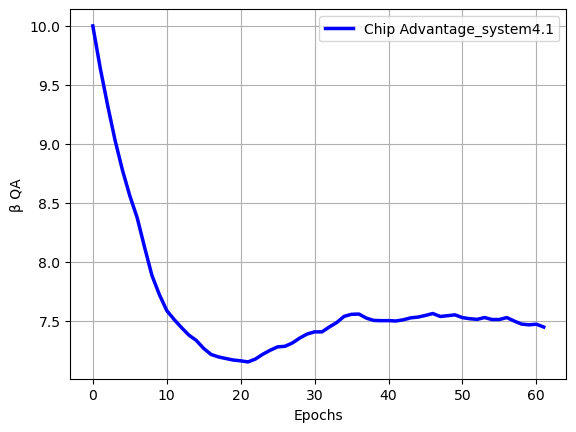

In [20]:
plt.plot(beta_list+beta_list_2, linewidth=2.5, color="b" )
plt.xlabel("Epochs")
plt.ylabel("β QA")
plt.legend([f'Chip {engine.model._qpu_sampler.properties["chip_id"]}'])
# plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/beta_QA_{engine.model._qpu_sampler.properties["chip_id"]}_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()
# engine.model.eval();
# (engine.model.prior._weight_dict['01'] == 0).sum(axis=1)

In [ ]:
engine.model.prior._no

In [25]:
# en_labels = []

xtarget_samples = []
xrecon_samples = []
xgen_samples = []
xgen_samples_qpu = []

# labelstarget_samples = []
# labelsrecon_samples = []
entarget_samples = []
with torch.no_grad():
    for xx in val_loader:
    # for xx in train_loader:
        in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1])
        if reducedata:
            in_data = engine._reduce(in_data, true_energy, R=R)
        fwd_output = engine.model((in_data, true_energy), False)
        if reducedata:
            in_data = engine._reduceinv(in_data, true_energy, R=R)
            recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
        elif scaled:
            in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
            recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True)
            sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy, measure_time=True, beta=1/beta)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
            sample_data_qpu = torch.tensor(engine._data_mgr.inv_transform(sample_data_qpu.detach().cpu().numpy()))
        else:
            in_data = in_data.detach().cpu()*1000
            recon_data = fwd_output.output_activations.detach().cpu()*1000
            engine._model.sampler._batch_size = true_energy.shape[0]
            sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
            engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
            # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
            sample_data = sample_data.detach().cpu()*1000

        # xrecon_samples.append( torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy())) )
    #     if engine._config.engine.cl_lambda:
    #         labelsrecon_samples.append(fwd_output.labels.detach().cpu())
    #         labelstarget_samples.append( nn.functional.one_hot(true_energy.divide(256).log2().to(torch.int64), num_classes=15).squeeze(1).to(torch.float).detach().cpu() )

    #         en_labels.append(true_energy.detach().cpu())

        xtarget_samples.append(in_data.detach().cpu())
        xrecon_samples.append( recon_data.detach().cpu())
        xgen_samples.append( sample_data.detach().cpu())
        xgen_samples_qpu.append( sample_data_qpu.detach().cpu())
        entarget_samples.append(true_energy.detach().cpu())

        # xtarget_samples.append( torch.tensor(engine._data_mgr.inv_transform(xx[0][0].detach().cpu().numpy())) )
    
    
xtarget_samples = torch.cat(xtarget_samples, dim=0)
xrecon_samples = torch.cat(xrecon_samples, dim=0)
xgen_samples = torch.cat(xgen_samples, dim=0)
xgen_samples_qpu = torch.cat(xgen_samples_qpu, dim=0)
entarget_samples = torch.cat(entarget_samples, dim=0)

# if engine._config.engine.cl_lambda:
#     labelstarget_samples = torch.cat(labelstarget_samples, dim=0)
#     labelsrecon_samples = torch.cat(labelsrecon_samples, dim=0)
#     en_labels = torch.cat(en_labels, dim=0)

#     lhat = torch.argmax(nn.Sigmoid()(labelsrecon_samples), dim=1).numpy()
#     l = torch.argmax(labelstarget_samples, dim=1).numpy()


In [26]:
(xgen_samples.sum(dim=0) == 0).sum()
(xrecon_samples.sum(dim=0) == 0).sum()
# (xtarget_samples.sum(dim=0) == 0).sum()
# print((xgen_samples.sum(dim=0) == 0).nonzero(as_tuple=True))
# print((xrecon_samples.sum(dim=0) == 0).nonzero(as_tuple=True))

tensor(152)

In [22]:
# # Each API call uses ~0.28% of Monthly Access
# engine._model.sampler._batch_size = true_energy.shape[0]
# sample_energies_qpu, sample_data_qpu = engine._model.generate_samples_qpu(num_samples=true_energy.shape[0], true_energy=true_energy)
# sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
# engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
2190/180

12.166666666666666

In [22]:
print("mean qpu time", np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_qpu[i][0] for i in range(9)]))
print("mean gpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)]), np.std([engine._model.sampling_time_gpu[i][0] for i in range(9)]))
print("mean gpu time/mean qpu time", np.mean([engine._model.sampling_time_gpu[i][0] for i in range(9)])/np.mean([engine._model.sampling_time_qpu[i][0] for i in range(9)]))


mean qpu time 0.07609847550176913 0.0015022773701042905
mean gpu time 2.0308878699110613 0.01634824490215739
mean gpu time/mean qpu time 26.68762884565076


In [119]:
# plt.hist(sample_energies.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(sample_energies_qpu.sum(dim=1).detach().cpu().numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")

In [160]:
THRSH=0
xrecon_samples = xrecon_samples * (xrecon_samples > THRSH)
xgen_samples = xgen_samples * (xgen_samples > THRSH)

In [27]:
directory_path = f'/home/javier/Projects/CaloQVAE/figs/{modelname}'
if not os.path.isdir(directory_path):
    os.mkdir(directory_path) 
else:
    pass

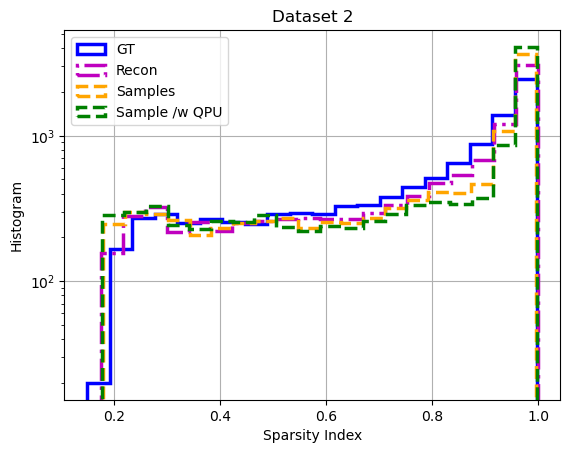

In [28]:
plt.hist(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(((xgen_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(((xgen_samples_qpu == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
plt.xlabel("Sparsity Index")
plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Samples", "Sample /w QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [36]:
# idxPrev = 0
# # for i,idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(1,5)]):
# # for i,idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step')
#     plt.xlabel("Sparsity Index")
#     plt.ylabel("Histogram")
#     plt.legend(["GT", "Recon", "Sample"])
#     plt.title(f'{part} Layer {i}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

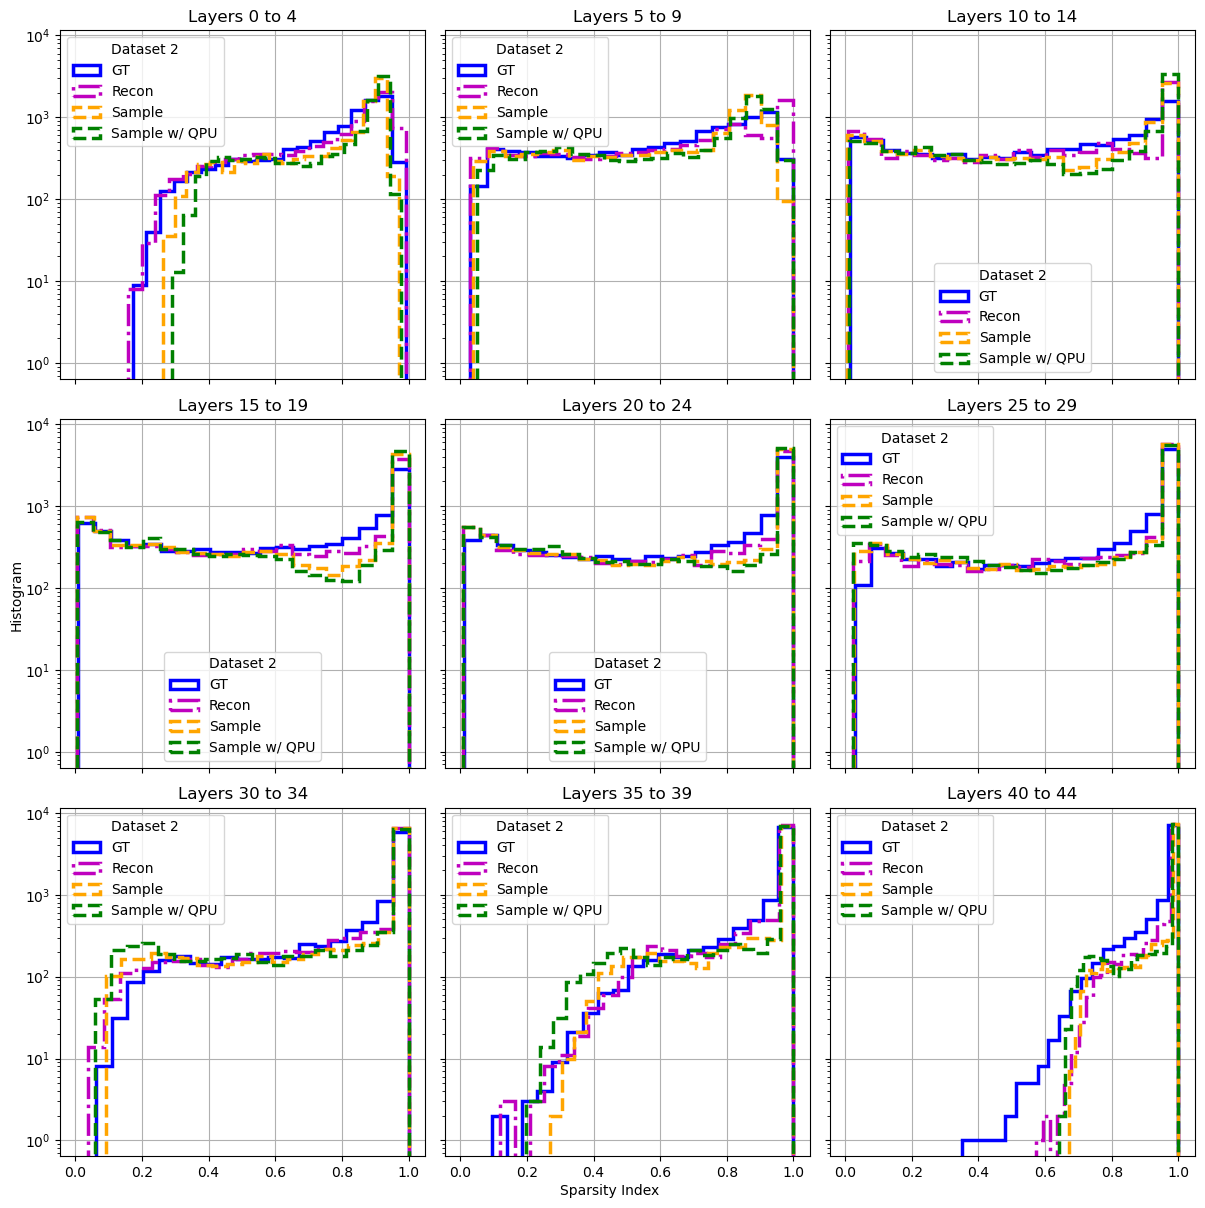

In [29]:
HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=True, tight_layout=True)
fig.text(0.5, 0.0, 'Sparsity Index', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(),  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(((xgen_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(((xgen_samples_qpu[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


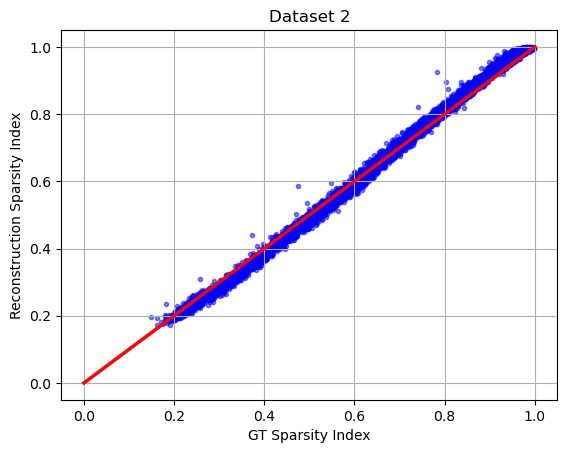

In [70]:
plt.scatter(((xtarget_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(), ((xrecon_samples == 0).sum(dim=1)/xtarget_samples.shape[1]).numpy(),  marker='.', alpha=.5, color="b")
plt.plot([0,1],[0,1], c='red', lw=2.5)
plt.xlabel('GT Sparsity Index')
plt.ylabel('Reconstruction Sparsity Index')
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sparsity_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [49]:
# idxPrev = 0
# for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(((xtarget_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), ((xrecon_samples[:, idxPrev:idx] == 0).sum(dim=1)/l).numpy(), marker='.', alpha=.2)
#     plt.plot([0,1],[0,1], c='red', lw=2)
#     plt.xlabel('sparsity index input')
#     plt.ylabel('sparsity index recon')
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/sparsity_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [30]:
E_right = 50000
E_left = 2000
tmp = (entarget_samples < E_right) * (entarget_samples > E_left)
idxEnFilter = (tmp == True).nonzero(as_tuple=True)[0]
len(idxEnFilter)

4674

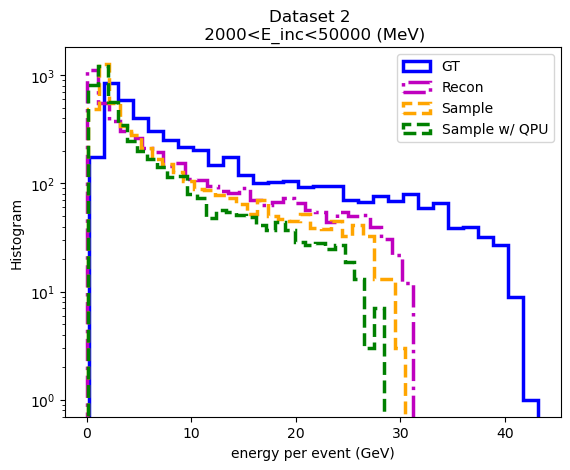

In [31]:
plt.hist(xtarget_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu[idxEnFilter,:].sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")

plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]} \n {E_left}<E_inc<{E_right} (MeV)')
# plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_slice_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

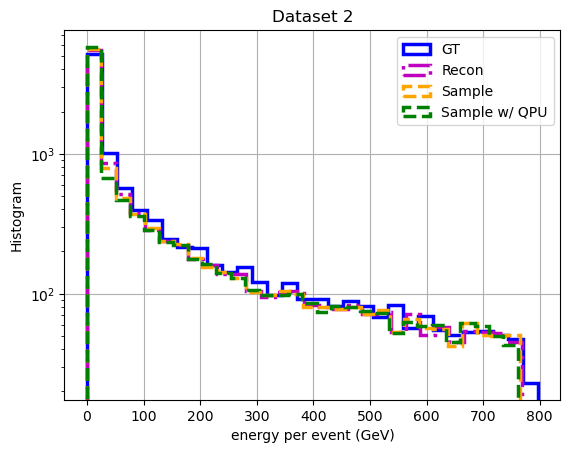

In [32]:
plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="m", linestyle="dashdot")
plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="orange", linestyle="dashed")
plt.hist(xgen_samples_qpu.sum(dim=1).numpy()/1000, bins=30, log=True, histtype='step', alpha=1.0, linewidth=2.5, color="green", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="b")
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(0, 100 + 1,2), log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
# plt.hist(xtarget_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xrecon_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
# plt.hist(xgen_samples.sum(dim=1).numpy()/1000, bins=np.arange(100+1, 1000 + 1,10), log=True, histtype='step')
plt.xlabel("energy per event (GeV)")
# plt.xscale('log')

plt.ylabel("Histogram")
plt.legend(["GT", "Recon", "Sample", "Sample w/ QPU"])
plt.title(f'{ds[part]}')
plt.grid("True")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

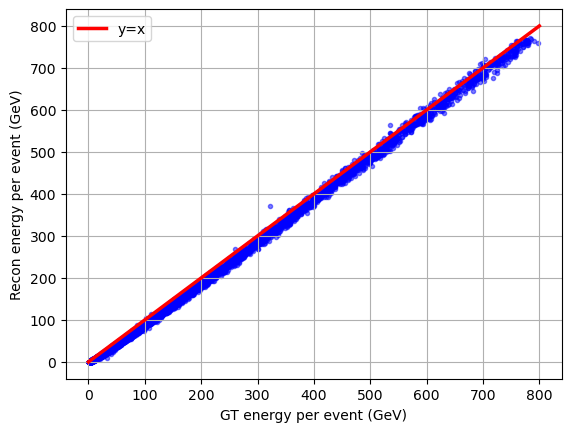

In [74]:
plt.scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
plt.plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
plt.legend()
plt.grid("True")
plt.xlabel("GT energy per event (GeV)")
plt.ylabel("Recon energy per event (GeV)")
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

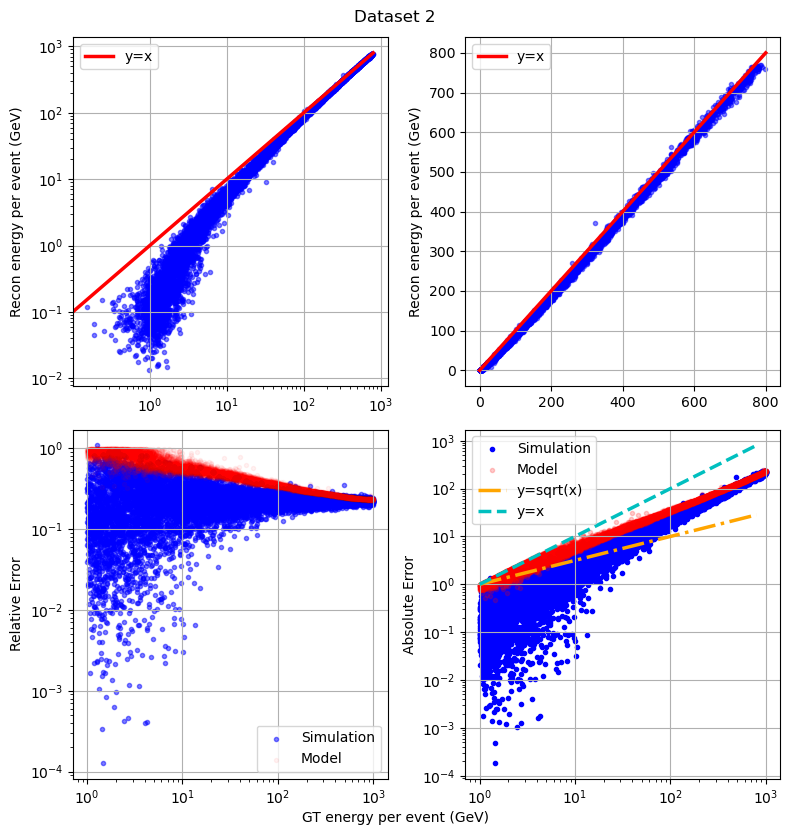

In [75]:
fig, axes = plt.subplots(2,2, figsize=(8,8), tight_layout=True)
fig.text(0.5, 0.0, 'GT energy per event (GeV)', ha='center')
fig.text(0.5, 1.0, f'{ds[part]}', ha='center', fontsize=12)

axes[0,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,0].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,0].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
axes[0,0].set_ylabel("Recon energy per event (GeV)")
axes[0,0].legend()
axes[0,0].grid("True")
axes[0,0].set_yscale('log')
axes[0,0].set_xscale('log')

axes[0,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, xrecon_samples.sum(dim=1).numpy()/1000, marker='.', alpha=.5, color="b")
axes[0,1].plot([0,800],[0,800], c='red', lw=2.5, label='y=x')
# axes[0,1].plot([0,3800],[0,3800], c='red', lw=2.5, label='y=x')
# plt.plot([0,20],[0,20], c='red', lw=2)
# axes[0,1].set_xlabel("GT energy per event (GeV)")
axes[0,1].set_ylabel("Recon energy per event (GeV)")
axes[0,1].legend()
axes[0,1].grid("True")

# axes[1,0].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy() - xrecon_samples.sum(dim=1).numpy())/(xtarget_samples.sum(dim=1).numpy()+1e-3), marker='.', alpha=.5, color="blue")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xtarget_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.5, color="blue", label="Simulation")
axes[1,0].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy() - xrecon_samples.sum(dim=1).numpy())/(entarget_samples.reshape(-1).numpy()+1e-3), marker='.', alpha=.05, color="red", label="Model")
# axes[1,0].set_title(f'{ds[part]}')
axes[1,0].grid("True")
axes[1,0].set_yscale('log')
axes[1,0].set_xscale('log')
axes[1,0].legend()
axes[1,0].set_ylabel("Relative Error")

# axes[1,1].scatter(xtarget_samples.sum(dim=1).numpy()/1000, np.abs(xtarget_samples.sum(dim=1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.5, color="blue")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xtarget_samples.sum(dim=1).numpy()/1000), marker='.', alpha=1, color="blue", label="Simulation")
axes[1,1].scatter(entarget_samples.numpy()/1000, np.abs(entarget_samples.reshape(-1).numpy()/1000 - xrecon_samples.sum(dim=1).numpy()/1000), marker='.', alpha=.2, color="red", label="Model")
axes[1,1].plot([1,800],np.sqrt([1,800]), c='orange', lw=2.5, label='y=sqrt(x)', linestyle="dashdot")
axes[1,1].plot([1,800],[1,800], c='c', lw=2.5, label='y=x', linestyle="dashed")
# axes[1,1].set_title(f'{ds[part]}')
axes[1,1].grid("True")
axes[1,1].set_yscale('log')
axes[1,1].set_xscale('log')
axes[1,1].set_ylabel("Absolute Error")
axes[1,1].legend()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_scatter_4panels_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()

In [159]:
# entarget_samples.reshape(-1)
xtarget_samples.sum(dim=1).shape

torch.Size([10000])

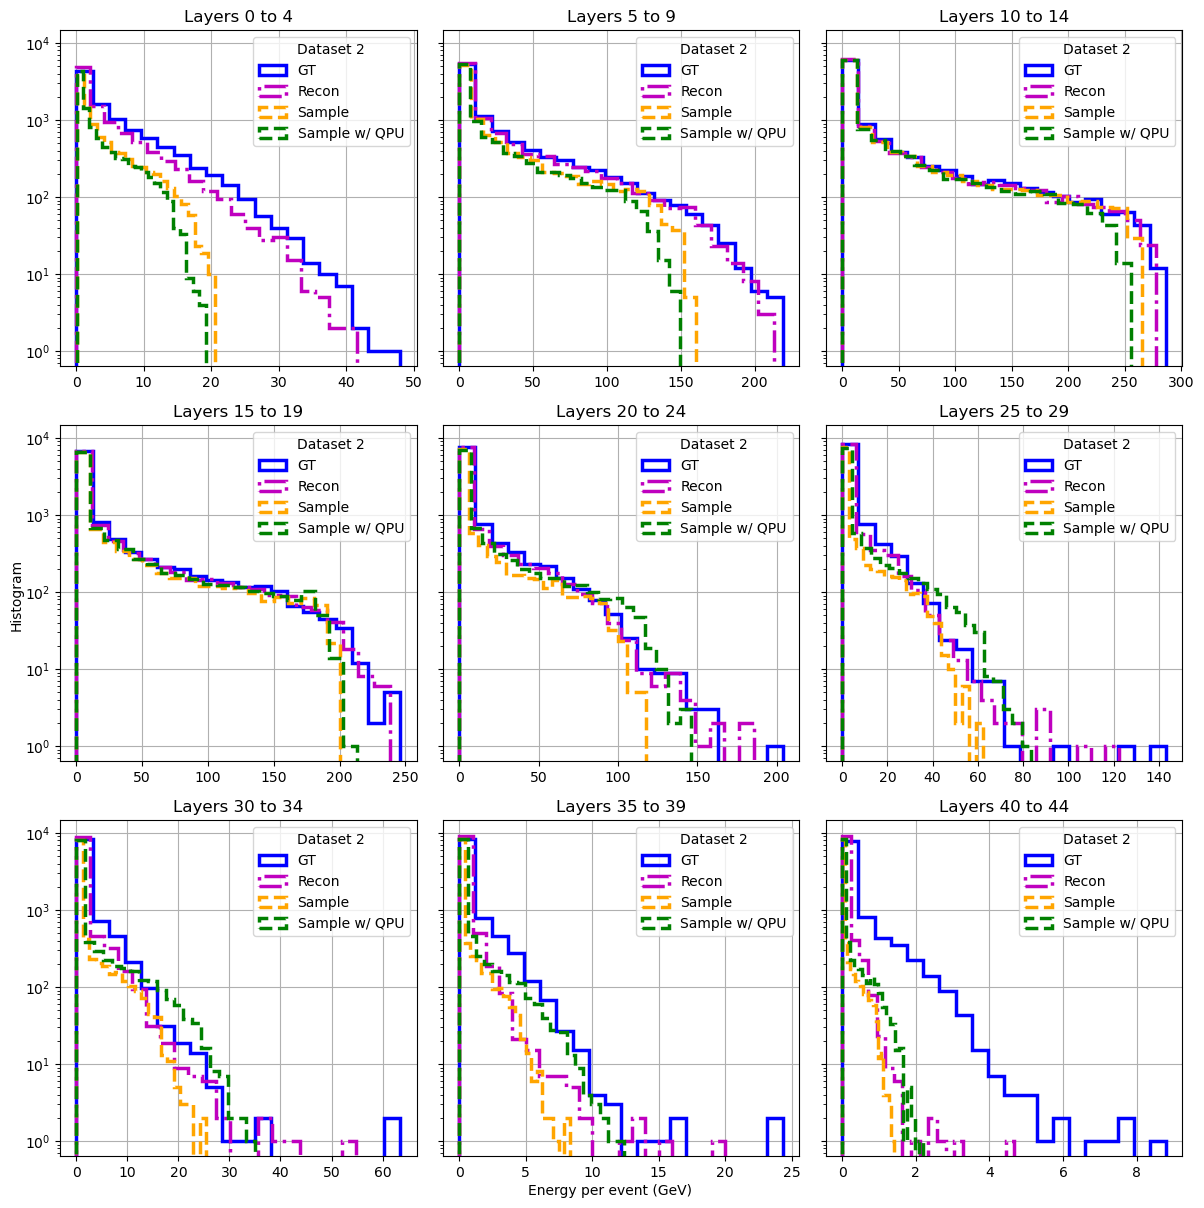

In [33]:
# HLF_1_electron.relevantLayers = [0,5,10,15,20,25,30,35,40,45]
# Create a grid of subplots
fig, axes = plt.subplots(3,3, figsize=(12, 12), sharey=True, sharex=False, tight_layout=True)
fig.text(0.5, 0.0, 'Energy per event (GeV)', ha='center')
fig.text(0.0, 0.5, 'Histogram', va='center', rotation='vertical')

# Iterate through the columns of X and plot histograms
for i,_ in enumerate(HLF_1_electron.relevantLayers[:-1]):
    row_index = i // 3  # Determine the row index
    col_index = i % 3   # Determine the column index
    
    ax = axes[row_index, col_index]  # Get the current subplot
    
    # Plot histogram for the current column
    idx = HLF_1_electron.relevantLayers[i+1]*9*16
    idxPrev = (HLF_1_electron.relevantLayers[i])*9*16
    l = idx - idxPrev
    ax.hist(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000,  bins=20, log=True, histtype='step', linewidth=2.5, color="b")
    ax.hist(xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="m", linestyle="dashdot")
    ax.hist(xgen_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="orange", linestyle="dashed")
    ax.hist(xgen_samples_qpu[:, idxPrev:idx].sum(dim=1).numpy()/1000, bins=20, log=True, histtype='step', linewidth=2.5, color="green", linestyle="dashed")
    ax.legend(["GT", "Recon", "Sample", "Sample w/ QPU"], title=f'{ds[part]}')
    ax.grid("True")
    
    # Set labels and title for the subplot
    # ax.set_xlabel(f'Column {i + 1}')
    # ax.set_ylabel('Frequency')
    ax.set_title(f'Layers {HLF_1_electron.relevantLayers[i]} to {HLF_1_electron.relevantLayers[i+1]-1}')

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/{modelname}/energy_per_layer_{modelname}_{arch}_{datascaled}_{part}.png')
plt.show()


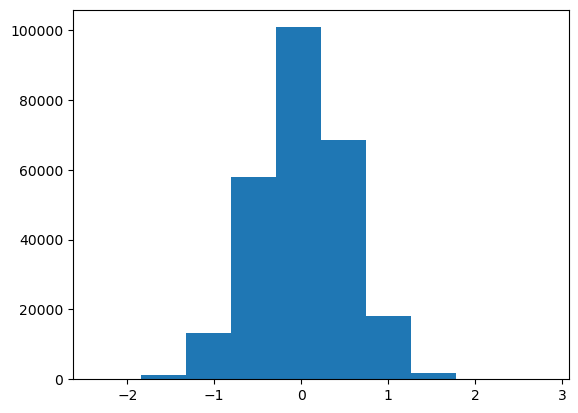

In [42]:
# plt.hist(engine._model.prior._weight_dict['23'].reshape(-1).detach().cpu().numpy())
# plt.show()
# engine._model.prior._weight_dict['01'].reshape(-1)

In [368]:
# idxPrev = 0
# # for i, idx in enumerate(np.unique(HLF_1_pions.bin_edges)[1:]):
# for i, idx in enumerate([16*9*i for i in range(10,20)]):
# # for i, idx in enumerate(np.unique(HLF_1_photons.bin_edges)[1:]):
#     l = idx - idxPrev
#     print('Layer ', i, l, ' voxels')
#     plt.scatter(xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy()/1000, marker='.', alpha=.2)
#     plt.plot([0,xtarget_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000],[0,xrecon_samples[:, idxPrev:idx].sum(dim=1).numpy().max()/1000], c='red', lw=2)
    
#     plt.xlabel("input energy per event (GeV)")
#     plt.ylabel("recon energy per event (GeV)")
#     plt.title(f'{part}')
#     # plt.savefig(f'/home/javier/Projects/CaloQVAE/figs/energy_scatter_{i}_{modelname}_{arch}_{datascaled}_{part}.png')
#     plt.show()
#     idxPrev = idx

In [151]:
np.unique(HLF_1_pions.bin_edges)

array([  0,   8, 108, 208, 213, 363, 523, 533])

In [153]:
xx = next(iter(val_loader))
in_data, true_energy, in_data_flat = engine._preprocess(xx[0],xx[1]) # input , label

In [35]:
if reducedata:
    in_data = engine._reduce(in_data, true_energy, R=R)
fwd_output = engine.model((in_data, true_energy), False)
if reducedata:
    in_data = engine._reduceinv(in_data, true_energy, R=R)
    recon_data = engine._reduceinv(fwd_output.output_activations, true_energy, R=R)
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    sample_data = engine._reduceinv(sample_data, sample_energies, R=R)
elif scaled:
    in_data = torch.tensor(engine._data_mgr.inv_transform(in_data.detach().cpu().numpy()))
    recon_data = torch.tensor(engine._data_mgr.inv_transform(fwd_output.output_activations.detach().cpu().numpy()))
    engine._model.sampler._batch_size = true_energy.shape[0]
    # try:
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    # except:
        # pass
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = torch.tensor(engine._data_mgr.inv_transform(sample_data.detach().cpu().numpy()))
else:
    in_data = in_data.detach().cpu()*1000
    recon_data = fwd_output.output_activations.detach().cpu()*1000
    engine._model.sampler._batch_size = true_energy.shape[0]
    sample_energies, sample_data = engine._model.generate_samples(num_samples=true_energy.shape[0], true_energy=true_energy)
    engine._model.sampler._batch_size = engine._config.engine.rbm_batch_size
    # sample_energies, sample_data = engine._model.generate_samples(num_samples=2048)
    sample_data = sample_data.detach().cpu()*1000

In [303]:
THRSH=7
recon_data = recon_data * (recon_data > THRSH)
sample_data = sample_data * (sample_data > THRSH)

In [44]:
HLF_1_pions.relevantLayers = [1,2,3,4,5,6,7]

In [121]:
HLF_1_electron.relevantLayers = [5,10,15,30,35]

In [45]:
# (((in_data[:,0:108] - recon_data[:,0:108])/(in_data[:,0:108]))**2).sum(dim=1).argsort()[:20]
(((in_data - recon_data)/(in_data+1e-5))**2).sum(dim=1).argsort()[-200:-1]
# (((in_data - recon_data))**2).sum(dim=1).argsort()[:20]

tensor([779, 684, 113, 335, 110, 119, 395, 151,  22, 171, 144, 709, 660, 313,
        298, 627, 109, 769, 189, 380, 214, 292, 404, 183, 410, 271, 149, 405,
        447, 653, 437, 334, 129, 289, 168,  36,  81,   4, 184, 143, 101, 159,
        629, 590, 284, 158, 435, 247, 757,  94, 729, 723, 181, 551, 642, 282,
          6, 316, 549, 391, 566, 702, 640, 496, 414, 486, 632, 136, 368, 643,
        767,  37,  75, 373, 553, 117, 630, 515,  27, 114, 196, 393, 658,  16,
        425,  93, 192, 349, 120, 178, 633, 616, 375,  96, 255, 204, 649,   2,
        154, 442, 164, 319, 300, 558, 215, 563, 736, 295, 253, 412,  39, 562,
        489, 501, 595, 721,  47, 205, 264, 753, 423, 720, 493,  59, 497, 461,
        661, 396, 417,  21, 523, 325, 297, 524, 186, 399, 663, 738, 195,  31,
        719, 507, 420, 418, 311, 288, 708, 116, 141, 536, 579, 140, 760, 754,
        452, 554, 198, 732, 145, 361, 366, 625,  83,  90, 619, 254, 468, 540,
        281, 727, 559, 212, 274,  14, 714, 752, 699, 219, 781, 3

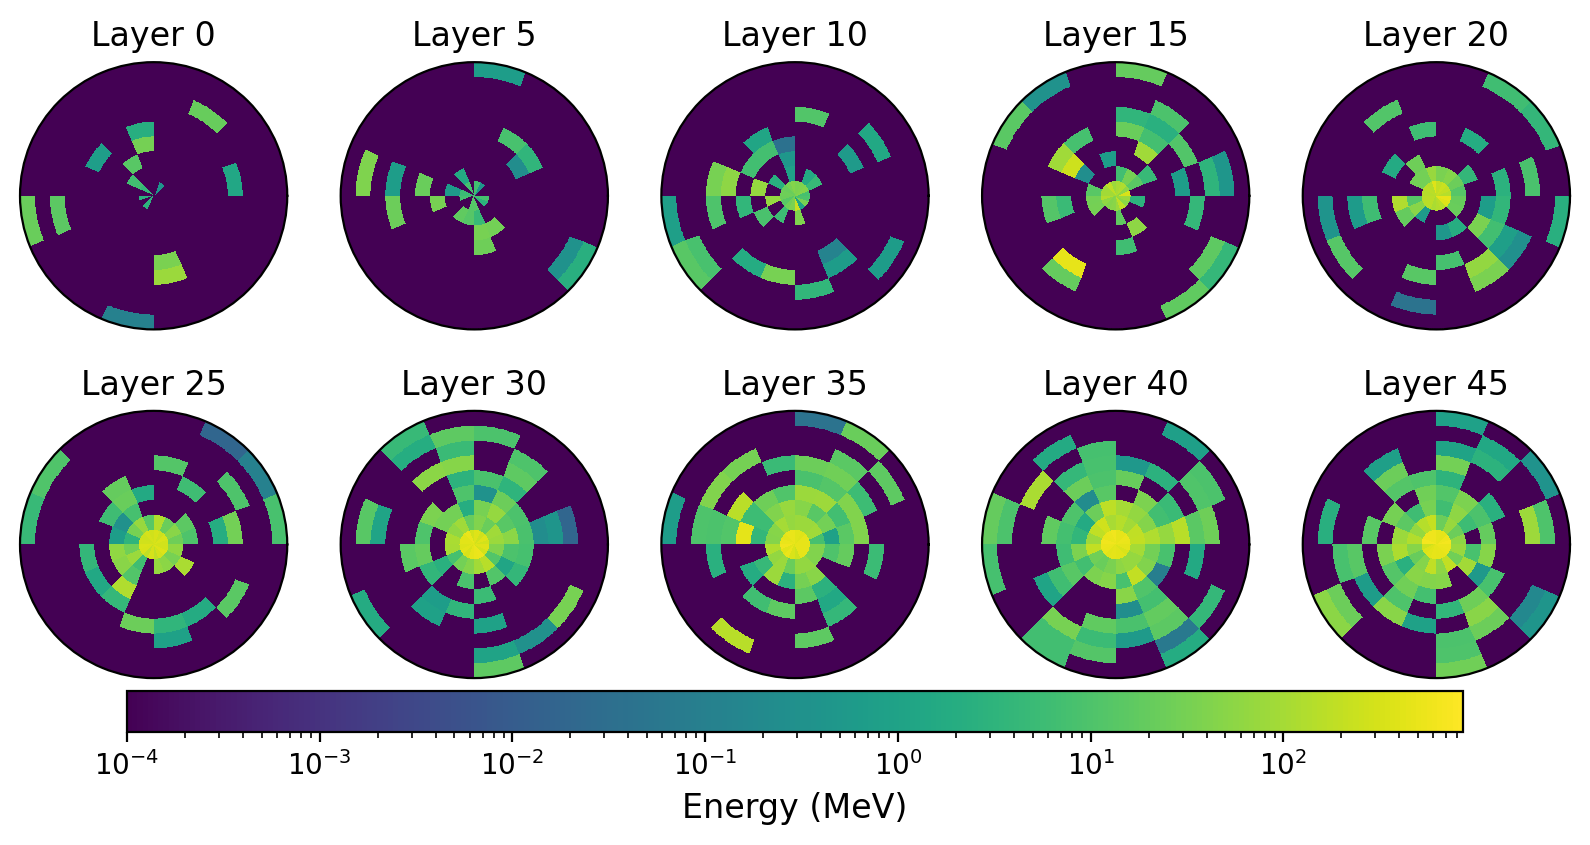

In [50]:
idx=779
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/target_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(in_data[idx,:].detach().cpu().numpy(), filename=None)


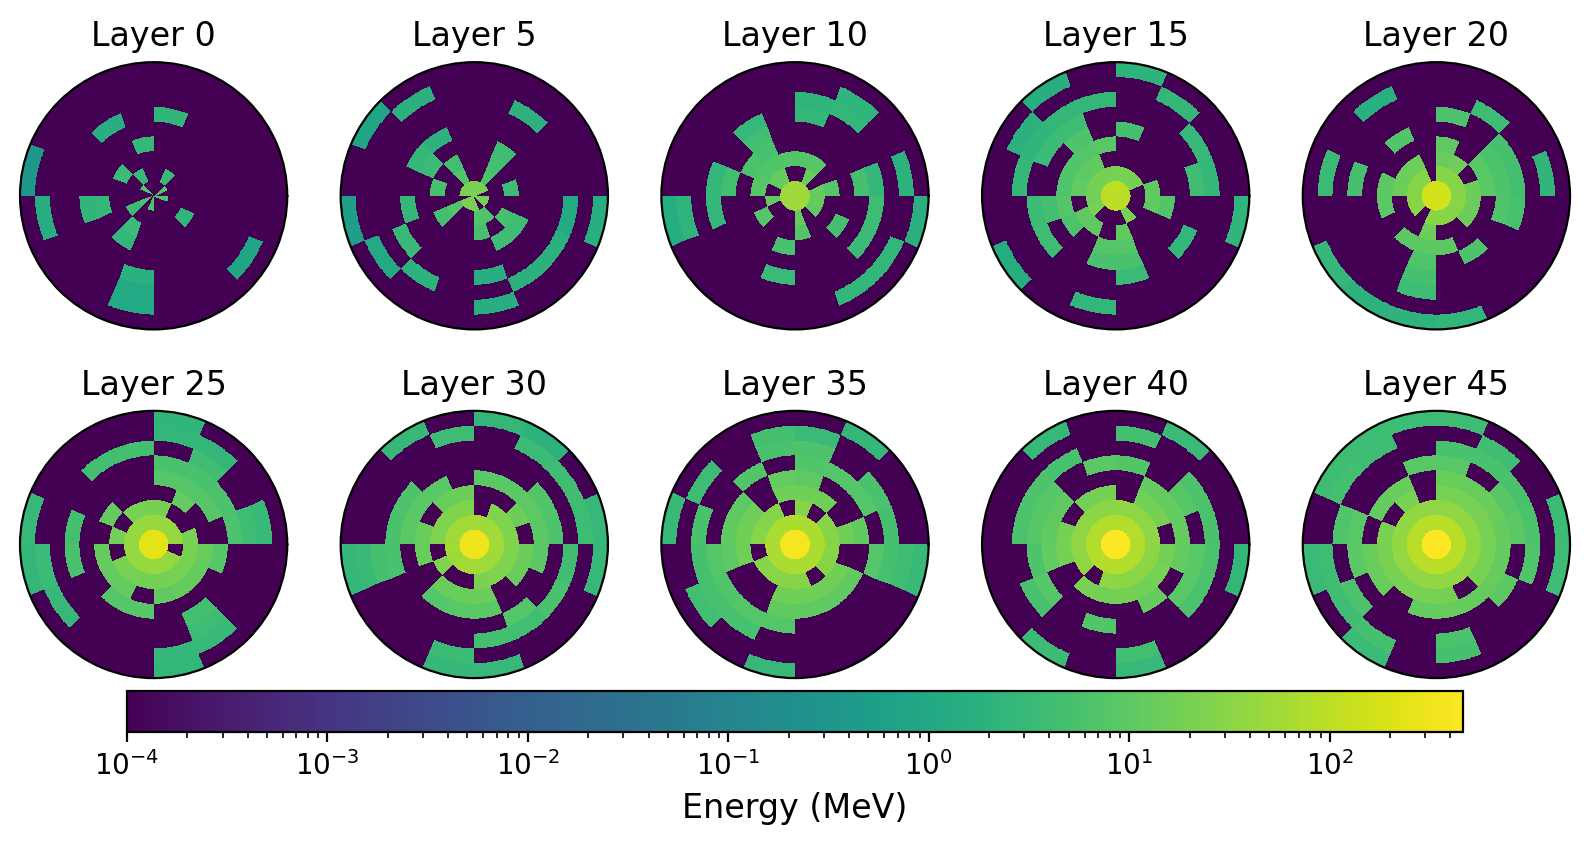

In [51]:
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/recon_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(recon_data[idx,:].detach().cpu().numpy(), filename=None)

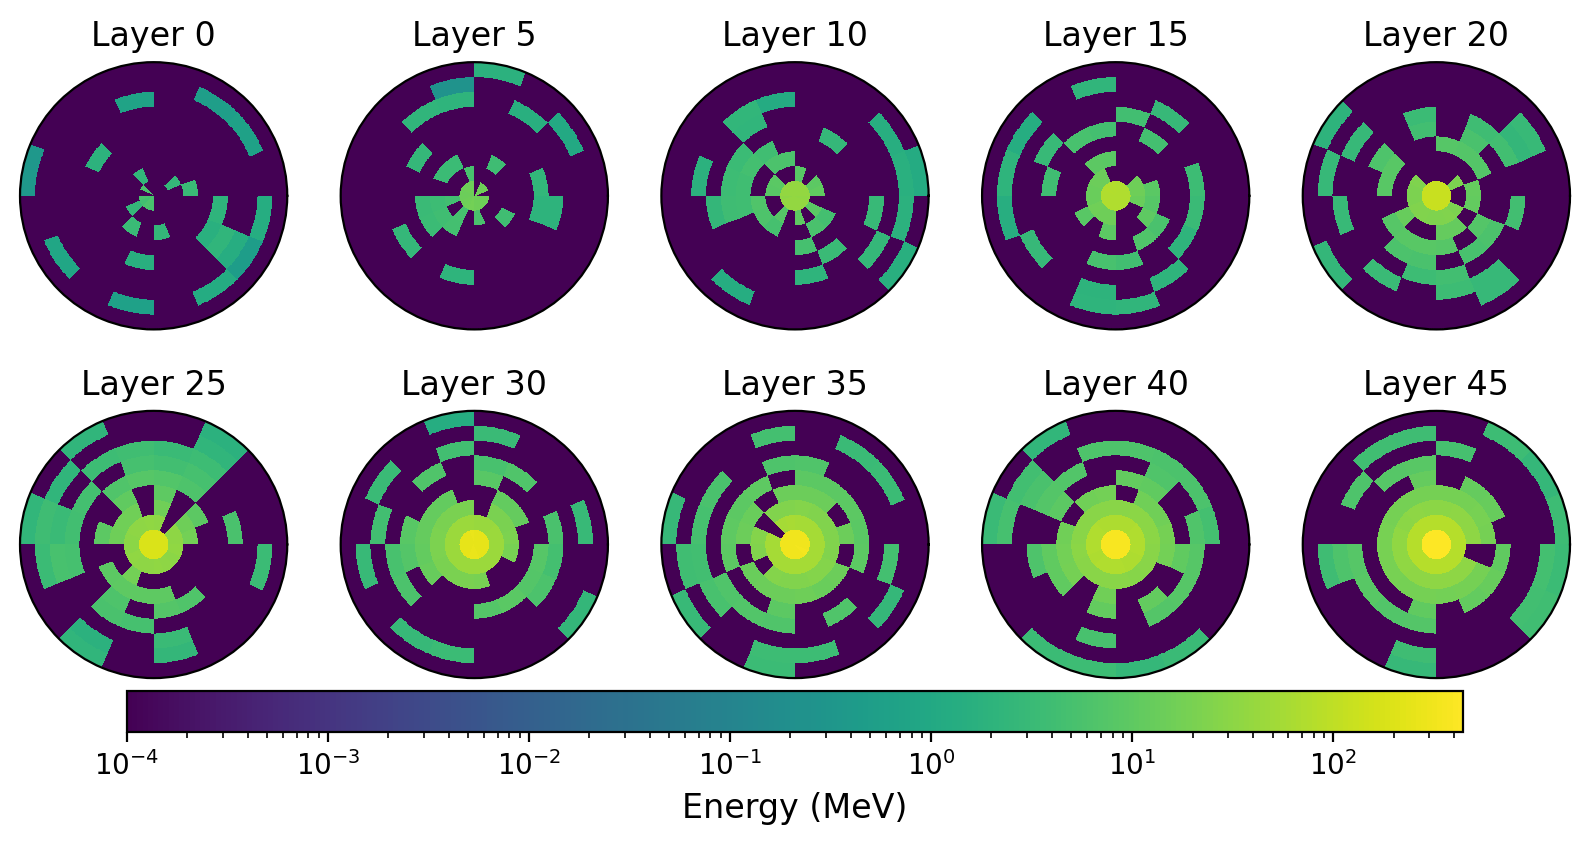

In [52]:
# HLF_1_pions.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)
# HLF_1_pions.DrawSingleShower(sample_data[1,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')

HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data[idx,:].detach().cpu().numpy(), filename=None)

In [103]:
# HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=f'/home/javier/Projects/CaloQVAE/figs/{modelname}/sample_QPU_a_{idx}_{modelname}_{arch}_{datascaled}_{part}.png')
HLF_1_electron.DrawSingleShower(sample_data_qpu[idx,:].detach().cpu().numpy(), filename=None)

IndexError: index 6480 is out of bounds for dimension 0 with size 784

In [74]:
#Average Shower
modelname

'northern-meadow-223'

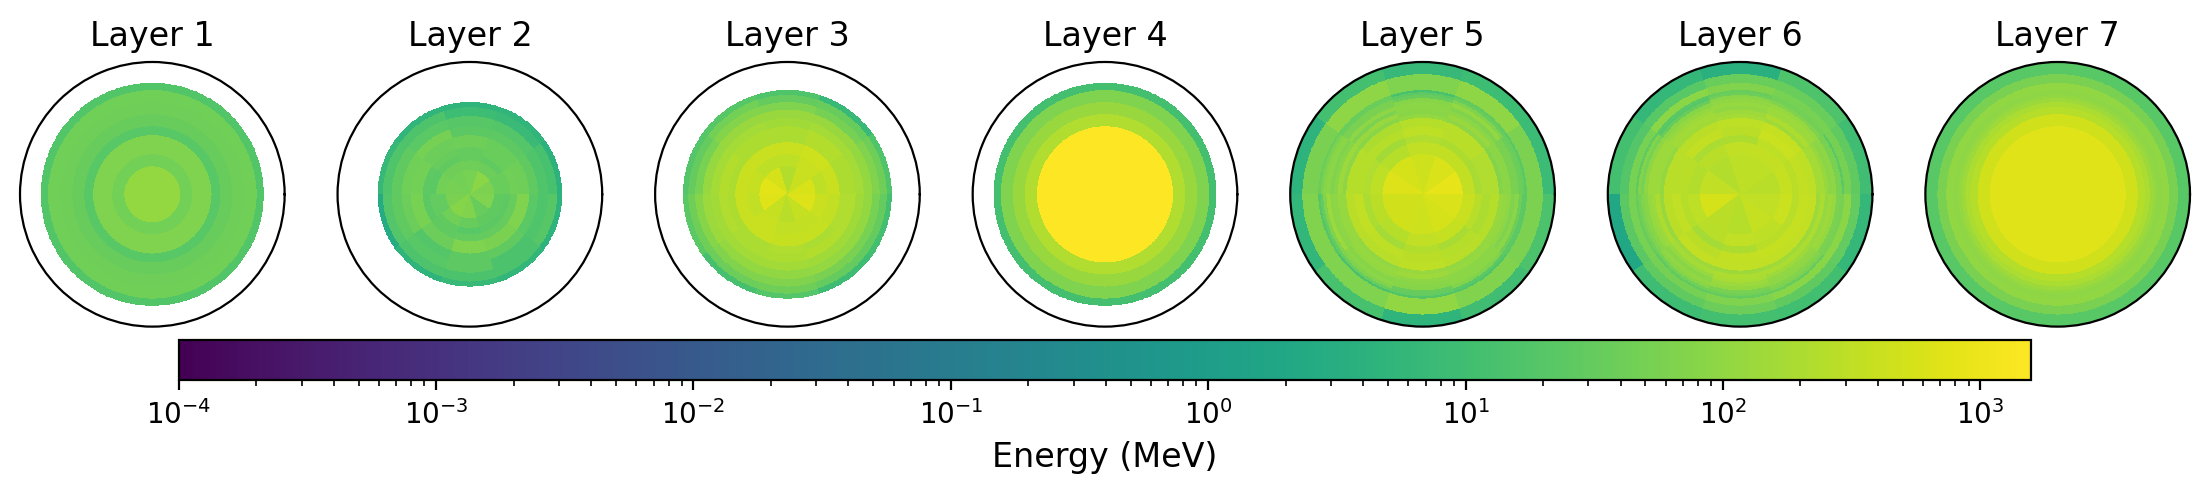

In [636]:
HLF_1_pions.DrawAverageShower(in_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

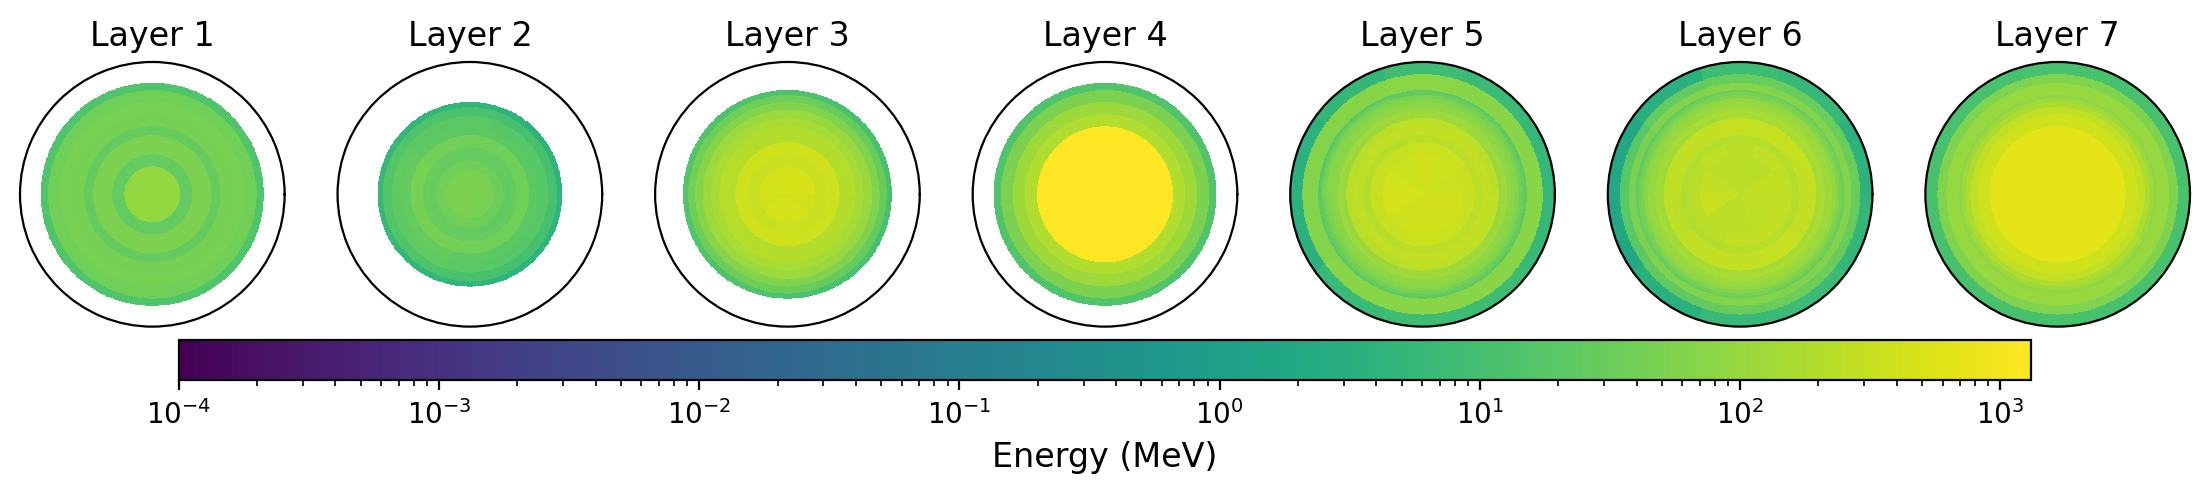

In [637]:
HLF_1_pions.DrawAverageShower(recon_data[idx:idx+100,:].detach().cpu().numpy(), filename=None)

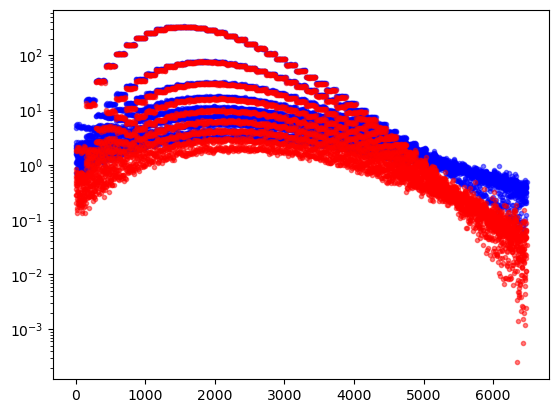

In [104]:
plt.plot(xtarget_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="b", linewidth=0)
plt.plot(xrecon_samples.mean(dim=0).numpy(), marker='.', alpha=.5, color="r", linewidth=0)
plt.yscale('log')
plt.yscale('log')
plt.show()

In [32]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.blk1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blk2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blk3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blk4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blk5 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(1024, 1024, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blkUp1 = nn.Sequential(
            nn.Conv2d(1024, 512, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(512, 512, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blkUp2 = nn.Sequential(
            nn.Conv2d(512, 256, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blkUp3 = nn.Sequential(
            nn.Conv2d(256, 128, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(128, 128, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.blkUp4 = nn.Sequential(
            nn.Conv2d(128, 64, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),

            nn.Conv2d(64, 64, 3, 1, 1),
            nn.LeakyReLU(negative_slope=0.0),
        )
        self.upConv1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(1024, 512, 3, 1, 1),
        )
        self.upConv2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(512, 256, 3, 1, 1),
        )
        self.upConv3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(256, 128, 3, 1, 1),
        )
        self.upConv4 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),
        )

    def forward(self, x):
        x1 = self.blk1(x)
        x2 = self.blk2(nn.MaxPool2d(2, stride=2)(x1))
        x3 = self.blk3(nn.MaxPool2d(2, stride=2)(x2))
        x4 = self.blk4(nn.MaxPool2d(2, stride=2)(x3))
        x5 = self.blk5(nn.MaxPool2d(2, stride=2)(x4))
        self.x5 = x5

        x6 = self.blkUp1(torch.cat((self.upConv1(x5), x4), dim=1))
        x7 = self.blkUp2(torch.cat((self.upConv2(x6), x3), dim=1))
        x8 = self.blkUp3(torch.cat((self.upConv3(x7), x2), dim=1))
        x9 = self.blkUp4(torch.cat((self.upConv4(x8), x1), dim=1))
        xfinal = nn.ConvTranspose2d(64, 1, 3, 1, 1)(x9)

        return xfinal

In [33]:
unet = UNet()

In [39]:
# unet(torch.rand(2,1,100,100)).shape

In [35]:
unet.x5.shape

torch.Size([2, 1024, 32, 32])

In [36]:
512*512

262144

In [37]:
1024*32*32

1048576